In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/clips.zip' -d '/content/drive/MyDrive/extracted_clips'


Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/extracted_clips/clips/common_voice_en_546218.mp3  
  inflating: /content/drive/MyDrive/extracted_clips/clips/common_voice_en_546220.mp3  
  inflating: /content/drive/MyDrive/extracted_clips/clips/common_voice_en_546221.mp3  
  inflating: /content/drive/MyDrive/extracted_clips/clips/common_voice_en_546222.mp3  
  inflating: /content/drive/MyDrive/extracted_clips/clips/common_voice_en_546223.mp3  
  inflating: /content/drive/MyDrive/extracted_clips/clips/common_voice_en_546308.mp3  
  inflating: /content/drive/MyDrive/extracted_clips/clips/common_voice_en_546320.mp3  
  inflating: /content/drive/MyDrive/extracted_clips/clips/common_voice_en_546534.mp3  
  inflating: /content/drive/MyDrive/extracted_clips/clips/common_voice_en_546545.mp3  
  inflating: /content/drive/MyDrive/extracted_clips/clips/common_voice_en_546834.mp3  
  inflating: /content/drive/MyDrive/extracted_clips/clips/common_voice_en_54684

In [ ]:
!pip install librosa pandas numpy scikit-learn tensorflow tqdm


In [ ]:
import pandas as pd

meta_path = '/content/drive/MyDrive/large_8gb_dataset/val.tsv'
df = pd.read_csv(meta_path, sep='\t')

# Filter unwanted/missing values
df = df.dropna(subset=['path', 'age', 'gender'])


In [ ]:
#Convert age and gender to numeric targets.

age_map = {'twenties':0, 'thirties':1, 'forties':2, 'fifties':3, 'sixties':4}
gender_map = {'male':0, 'female':1}
df['age_label'] = df['age'].map(age_map)
df['gender_label'] = df['gender'].map(gender_map)


In [ ]:
import librosa
test_path = '/content/drive/MyDrive/extracted_clips/clips/' + df.iloc[0]['path']
audio, sr = librosa.load(test_path, sr=None)
print(audio.shape, sr)


(170496,) 32000


In [ ]:
import librosa
import numpy as np
from tqdm import tqdm
import os

# Robust MFCC extraction function
def extract_mfcc(file_path, max_len=120, n_mfcc=40):
    try:
        y, sr = librosa.load(file_path, sr=None)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc).T
        if mfcc.shape[0] < max_len:
            pad_width = max_len - mfcc.shape[0]
            mfcc = np.pad(mfcc, ((0, pad_width), (0, 0)), mode='constant')
        else:
            mfcc = mfcc[:max_len]
        return mfcc
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None
features, ages, genders = [], [], []
for idx, row in tqdm(df.iterrows(), total=len(df)):
    audio_path = f"/content/drive/MyDrive/extracted_clips/clips/{row['path']}"
    if not os.path.exists(audio_path):
        print(f"File not found: {audio_path}")
        continue
    mfcc = extract_mfcc(audio_path)
    if mfcc is not None:
        features.append(mfcc)
        ages.append(row['age_label'])
        genders.append(row['gender_label'])
print(f"Extracted features: {len(features)}")


100%|██████████| 15832/15832 [37:13<00:00,  7.09it/s]

Extracted features: 15832


In [ ]:
print(f"Extracted features: {len(features)}")
print(f"DataFrame rows: {len(df)}")


Extracted features: 15832
DataFrame rows: 15832


In [ ]:
X = np.array(features)
y_age = np.array(ages)
y_gender = np.array(genders)
np.save('/content/drive/MyDrive/extracted_clips/features.npy', X)
np.save('/content/drive/MyDrive/extracted_clips/labels_age.npy', y_age)
np.save('/content/drive/MyDrive/extracted_clips/labels_gender.npy', y_gender)


In [ ]:
import os
print(os.listdir('/content/drive/MyDrive/extracted_clips'))


['clips', 'features.npy', 'labels_age.npy', 'labels_gender.npy']


In [ ]:
import numpy as np

X = np.load('/content/drive/MyDrive/extracted_clips/features.npy')
y_age = np.load('/content/drive/MyDrive/extracted_clips/labels_age.npy')
y_gender = np.load('/content/drive/MyDrive/extracted_clips/labels_gender.npy')


In [ ]:
from sklearn.model_selection import train_test_split

# For age prediction
X_train, X_test, y_train, y_test = train_test_split(X, y_age, test_size=0.2, random_state=42)


In [ ]:
print(np.unique(y_age))


[0 1 3 4]


In [ ]:
import numpy as np

# Suppose y_age is your original label array
unique_labels = np.unique(y_age)
label_map = {old_label: new_label for new_label, old_label in enumerate(unique_labels)}
y_age_mapped = np.array([label_map[label] for label in y_age])
print(np.unique(y_age_mapped))  # Should print [0 1 2 3]


[0 1 2 3]


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_age_mapped, test_size=0.2, random_state=42)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

num_classes = len(np.unique(y_age_mapped))  # Should be 4

model = Sequential([
    LSTM(128, input_shape=(X.shape[1], X.shape[2])),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)


Epoch 1/20
317/317 ━━━━━━━━━━━━━━━━━━━━ 71s 214ms/step - accuracy: 0.6510 - loss: 0.9753 - val_accuracy: 0.6814 - val_loss: 0.8959
Epoch 2/20
317/317 ━━━━━━━━━━━━━━━━━━━━ 81s 211ms/step - accuracy: 0.6794 - loss: 0.9016 - val_accuracy: 0.6814 - val_loss: 0.8849
Epoch 3/20
317/317 ━━━━━━━━━━━━━━━━━━━━ 83s 213ms/step - accuracy: 0.6863 - loss: 0.8866 - val_accuracy: 0.6814 - val_loss: 0.8893
Epoch 4/20
317/317 ━━━━━━━━━━━━━━━━━━━━ 68s 215ms/step - accuracy: 0.6885 - loss: 0.8602 - val_accuracy: 0.6810 - val_loss: 0.8754
Epoch 5/20
317/317 ━━━━━━━━━━━━━━━━━━━━ 66s 208ms/step - accuracy: 0.6819 - loss: 0.8643 - val_accuracy: 0.6810 - val_loss: 0.8741
Epoch 6/20
317/317 ━━━━━━━━━━━━━━━━━━━━ 72s 228ms/step - accuracy: 0.6961 - loss: 0.8495 - val_accuracy: 0.6822 - val_loss: 0.8705
Epoch 7/20
317/317 ━━━━━━━━━━━━━━━━━━━━ 68s 214ms/step - accuracy: 0.6918 - loss: 0.8416 - val_accuracy: 0.6834 - val_loss: 0.8674
Epoch 8/20
317/317 ━━━━━━━━━━━━━━━━━━━━ 84s 219ms/step - accuracy: 0.6900 - loss: 0

In [ ]:
score = model.evaluate(X_test, y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


99/99 ━━━━━━━━━━━━━━━━━━━━ 9s 92ms/step - accuracy: 0.6870 - loss: 0.8140
Test loss: 0.8110651969909668
Test accuracy: 0.6956110000610352


In [ ]:
# Save as a .keras file (recommended for new projects)
model.save('my_model.keras')

# Or save as a .h5 file (older format, still widely used)
model.save('my_model.h5')


NameError: name 'model' is not defined

In [ ]:
model.save('/content/drive/MyDrive/my_model.keras')
# or
model.save('/content/drive/MyDrive/my_model.h5')

In [ ]:
from tensorflow import keras
model = keras.models.load_model('/content/drive/MyDrive/my_model.keras')
# or
model = keras.models.load_model('/content/drive/MyDrive/my_model.h5')
score = model.evaluate(X_test, y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 9 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.6870 - loss: 0.8140
Test loss: 0.8110651969909668
Test accuracy: 0.6956110000610352


99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step
[[2124   24    4    0]
 [ 651   37    0    0]
 [ 190    2   42    0]
 [  92    0    1    0]]


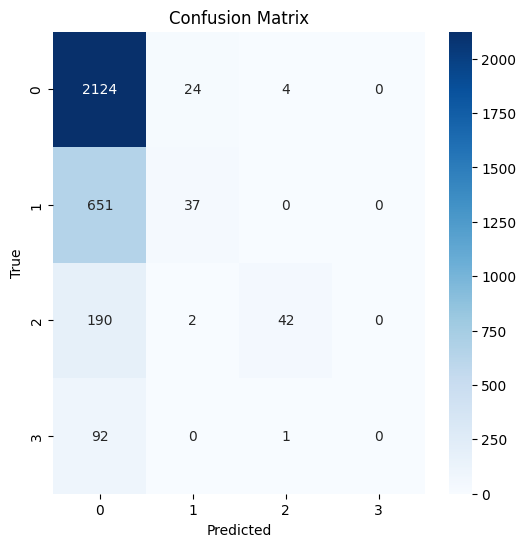

In [ ]:
# If your model outputs probabilities, use argmax to get the predicted class for each sample
y_pred = model.predict(X_test).argmax(axis=1)
# If your labels are one-hot encoded, convert y_test to class indices as well
y_true = y_test.argmax(axis=1) if y_test.ndim > 1 else y_test
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)
print(cm)
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from tensorflow import keras
model = keras.models.load_model('/content/drive/MyDrive/my_model.h5')
print(model.input_shape)
print(model.output_shape)
# should print something like: (None, TIME_STEPS, NUM_FEATURES)



(None, 120, 40)
(None, 4)


In [ ]:
age_probs, gender_probs = model.predict(features)
age_idx = np.argmax(age_probs[0])
gender_idx = np.argmax(gender_probs[0])
print(model.output_shape)

NameError: name 'features' is not defined